# TüEyeQ dataset validation
Extracking data for comparison with other dataset. 

In [58]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
import os
from tqdm import tqdm
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split, KFold
from sklearn.metrics import f1_score, roc_auc_score, plot_roc_curve, accuracy_score
from sklearn.dummy import DummyClassifier
from sklearn.preprocessing import Normalizer

### Loading the participant features
The table below holds the info we have on each participant. Each participant has a unique subject ID. The info about the tasks was removed, as it was deemed unnecessary. Our taget value should be age / gender.

In [2]:
participant_features = pd.read_csv('TuEyeQ/cft_full.csv', index_col=1)
del participant_features['task_id']
del participant_features['cft_task']
participant_features = participant_features.drop_duplicates()
participant_features.head()

,age,gender,handedness,native_german,native_german_mother,native_language_mother,native_german_father,native_language_father,education_mother,education_father,...,leisure_hobbies,leisure_play_games,leisure_relaxation,leisure_social_activity,leisure_humanitarian_services,leisure_nature_activities,leisure_travel_tourism,study_subject_primary,study_subject_secondary,cft_sum_full
subject,,,,,,,,,,,,,,,,,,,,,
AAB14,19.0,2.0,1.0,1.0,0.0,Türkisch,0.0,Italienisch,2.0,0.0,...,0,0,0,1,0,1,0,"Social sciences, journalism and information",NaN,28.0
AAO14,27.0,2.0,1.0,0.0,0.0,Englisch,0.0,Hindi,NaN,4.0,...,1,0,0,0,0,0,0,"Natural sciences, mathematics and statistics",NaN,30.0
AAR28,29.0,1.0,1.0,1.0,1.0,NaN,1.0,NaN,3.0,5.0,...,0,1,0,0,0,1,1,Education,Arts and humanities,35.0
ABT22,21.0,2.0,1.0,1.0,1.0,NaN,0.0,Serbisch,5.0,4.0,...,0,0,0,0,0,0,1,"Business, administration and law",NaN,37.0
ACB13,25.0,1.0,2.0,1.0,1.0,NaN,1.0,NaN,3.0,5.0,...,0,0,0,0,0,0,0,"Business, administration and law",NaN,28.0


### Reading eye tracking features
 Here is what eye tracking features for Some of the participants and some readings have been removed due to too much noise. 

In [3]:
eye_tracking_features_path = 'TuEyeQ/EyeMovementData/split'
arbitrary_eye_tracking_features = pd.read_csv(eye_tracking_features_path+'/ABT22/task_01.csv', index_col=0)
arbitrary_eye_tracking_features['gender'] = participant_features.loc['ABT22']['gender']
arbitrary_eye_tracking_features.head(6)

,starttime,duration,meanPupilDiameter,eye,eventType,eventIdxLeft,eventIdxRight,meanX,meanY,startSaccadeX,startSaccadeY,endSaccadeX,endSaccadeY,microsaccadeCount,microsaccadeAmplitude,microsaccadePeakVelocity,gender
14,3032142,44,NaN,left,saccade,1.0,NaN,NaN,NaN,514.678,410.290,701.580,311.073,NaN,NaN,NaN,2.0
15,3032146,40,NaN,right,saccade,1.0,4.0,NaN,NaN,554.941,409.684,713.569,319.930,NaN,NaN,NaN,2.0
16,3032190,100,3.053042,left,fixation,1.0,NaN,714.207654,299.538000,NaN,NaN,NaN,NaN,0.0,NaN,NaN,2.0
17,3032190,104,3.053560,right,fixation,1.0,5.0,729.511444,305.095778,NaN,NaN,NaN,NaN,2.0,3.521654,10.08638,2.0
18,3032294,24,NaN,left,saccade,2.0,NaN,NaN,NaN,721.452,301.986,804.455,229.362,NaN,NaN,NaN,2.0
19,3032298,20,NaN,right,saccade,2.0,5.0,NaN,NaN,741.377,292.951,818.070,220.246,NaN,NaN,NaN,2.0


### Appending target values to feature vectors
We want a feature vector to consist of eye tracking features and then a target value in the end, based on the subject ID.

In [4]:
participants = list(set(participant_features.index))

def load_participant(participant_id):
    tasks = []
    
    if not os.path.isdir(eye_tracking_features_path+'/'+participant_id):
        #print(participant_id+' has no readings.')
        return
    
    for task in os.listdir(eye_tracking_features_path+'/'+participant_id):
        df = pd.read_csv(eye_tracking_features_path+'/'+participant_id+'/'+task, index_col=0)
        gender = participant_features.loc[participant_id]['gender']
        age = participant_features.loc[participant_id]['age']
        df['gender'] = gender
        df['age'] = age
        tasks.append(df)
        
    return tasks

def drop_nulls(lst):
    return list(filter(None, lst))

In [5]:
abt22 = load_participant('ABT22')

### Making a heat map
It might be a good idea to visualise the data before attacking it. Perhaps we can even see a difference. Here I make a heatmap of the locations the male and female participants look and scanpaths.

In [6]:
all_males = participant_features[participant_features['gender']==1].index
all_females = participant_features[participant_features['gender']==2].index

all_male_readings = drop_nulls([load_participant(subject) for subject in tqdm(all_males)])
all_female_readings = drop_nulls([load_participant(subject) for subject in tqdm(all_females)])

100%|████████████████████████████████████████████████████████████████████████████████| 217/217 [01:01<00:00,  3.54it/s]


In [7]:
def make_heatmap_scanpath(readings, verbose=True):
    heatmaps, all_x, all_y = [], [], []

    for subject_ind, subject in tqdm(enumerate(readings)):
        for reading_ind, i in enumerate(subject):
            fixations = i[i['eventType']=='fixation']
            mean_x = fixations['meanX']
            mean_y = fixations['meanY']

            if mean_x.shape[0] < 2 and mean_y.shape[0] < 2:
                if verbose:
                    print(f"Reading {reading_ind} on subject {subject_ind} too small to work with.")
                break
            heatmap, x_edges, y_edges = np.histogram2d(mean_x, mean_y, bins=(20,40))
            heatmaps.append(heatmap)
            all_x.append(mean_x)
            all_y.append(mean_y)

    combined_heatmap = sum(heatmaps)
    if verbose:
        print("Drawing...")
    plt.figure(figsize=(10,8))
    plt.subplot(2,1,1)
    plt.imshow(combined_heatmap);
    ax = plt.gca() # Inverter x-akse. Den passede ikke af en eller anden årsag.
    ax.invert_xaxis()
    
    plt.subplot(2,1,2)
    for x, y in zip(all_x, all_y):
        plt.plot(x, y, linewidth=0.1/len(readings), c='blue')

52it [00:02, 21.06it/s]


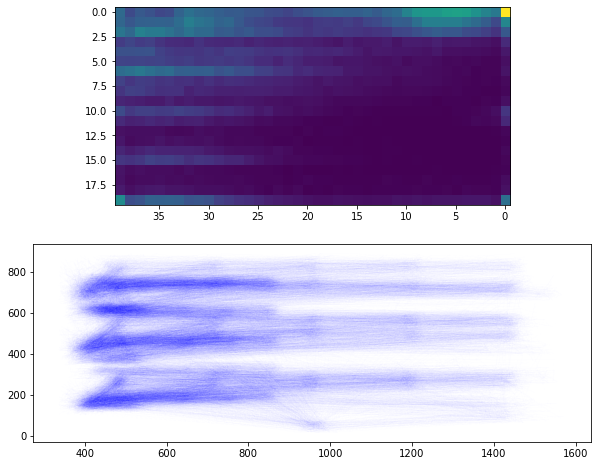

In [8]:
make_heatmap_scanpath(all_male_readings, verbose=False)

130it [00:05, 22.14it/s]


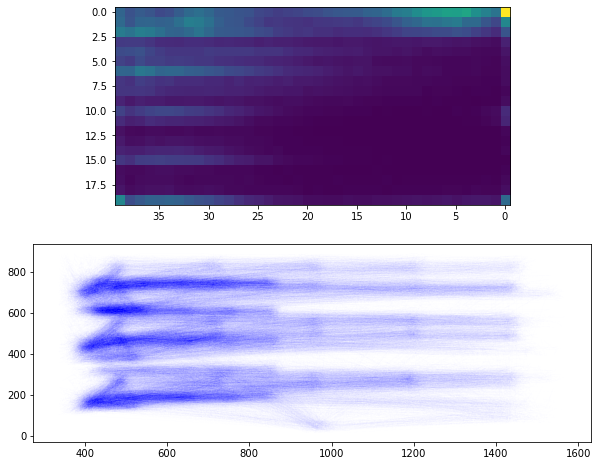

In [9]:
make_heatmap_scanpath(all_female_readings, verbose=False)

### Random Forest Classification

In [10]:
rfc = RandomForestClassifier(
    n_estimators=1000, criterion='entropy', min_samples_split=5,
    min_samples_leaf=1, random_state=42, max_features='sqrt'
)

dummy = DummyClassifier()

#The features available in all entries - Except start time.
feats = ['duration', 'meanPupilDiameter', 'eventIdxLeft', 'eventIdxRight', 'meanX', 'meanY',
         'startSaccadeX', 'startSaccadeY', 'endSaccadeX', 'endSaccadeY', 'microsaccadeCount',
        'microsaccadeAmplitude', 'microsaccadePeakVelocity']

X_prepared = [i for p in all_male_readings+all_female_readings[:52] for i in p]
X_prepared = [d.mean() for d in X_prepared] #Take the mean of all values - To make single feature vector
X_prepared = [x for x in X_prepared if not np.isnan(x.loc['gender'])] #Remove nan-values.
X_prepared = [x.fillna(0) for x in X_prepared]
np.random.shuffle(X_prepared)
X = [x.loc[feats] for x in X_prepared] #Take all features except last two
y = [x.loc['gender'] for x in X_prepared] # Take gender (last feature)

5it [01:25, 17.20s/it]


Average Accuracy: 0.7095037643055264
Average F1: 0.707082656550887
Average AUC: 0.7095215501840848


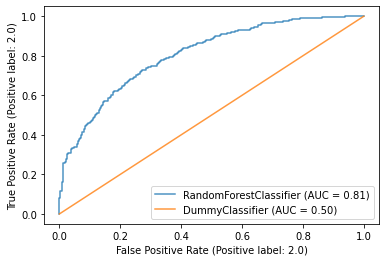

In [11]:
#Fit that model
acc_score = []
f1 = []
auc = []

X = np.array(X)
y = np.array(y)

k = 5
kf = KFold(n_splits=k, shuffle=False)
for train_index, test_index in tqdm(kf.split(X)):
    X_train, X_test = X[train_index], X[test_index]
    y_train, y_test = y[train_index], y[test_index]
    
    rfc.fit(X_train,y_train)
    pred_values = rfc.predict(X_test)
    
    acc_score.append(accuracy_score(y_test, pred_values))
    f1.append(f1_score(y_test, pred_values))
    auc.append(roc_auc_score(y_test, pred_values))

dummy.fit(X_train, y_train)
ax = plt.gca()
rfc_disp = plot_roc_curve(rfc, X_test, y_test, ax=ax, alpha=0.8)
rfc_disp = plot_roc_curve(dummy, X_test, y_test, ax=ax, alpha=0.8)
    
rfc_avg_acc_score = sum(acc_score)/k
rfc_avg_f1_score = sum(f1)/k
rfc_avg_auc_score = sum(auc)/k

print('Average Accuracy:', rfc_avg_acc_score)
print('Average F1:', rfc_avg_f1_score)
print('Average AUC:', rfc_avg_auc_score)

In [12]:
#tæl male/female.

y = np.array(y, dtype=int)
np.bincount(y)

array([   0, 2832, 2841], dtype=int64)

In [13]:
preds = dummy.predict(X_test)
print(accuracy_score(y_test, preds))
print(f1_score(y_test, preds))
print(roc_auc_score(y_test, preds))

0.4973544973544973
0.0
0.5


In [14]:
preds, y_test

(array([2., 2., 2., ..., 2., 2., 2.]), array([1., 1., 2., ..., 1., 1., 1.]))

In [15]:
len(all_female_readings[:52])

52

In [78]:
#Normaliserede pupil-means
pups = np.array([x['meanPupilDiameter'] for x in X_prepared])
pups = (pups - np.min(pups))/np.ptp(pups)

In [81]:
pups.min()

0.0

In [45]:
x = np.array([x['meanY'] for x in X_prepared])
min(x), max(x)

(0.0, 839.0359140897777)